In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
import cvxpy as cp
from sklearn.cluster import AgglomerativeClustering

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [3]:
"""
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)
pd.set_option('display.max_rows', 20 )
SP_Close
"""

"\nresp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')\nsoup = bs.BeautifulSoup(resp.text, 'lxml')\ntable = soup.find('table', {'class': 'wikitable sortable'})\ntickers = []\nfor row in table.findAll('tr')[1:]:\n    ticker = row.findAll('td')[0].text\n    tickers.append(ticker)\n\ntickers = [s.replace('\n', '') for s in tickers]\nstart = datetime(2000,1,1)\nend = datetime(2022,1,1)\ndata = yf.download(tickers, start=start, end=end)\n\ndata.index = pd.to_datetime(data.index)\ndata = data.sort_index()\nSP_Close = data['Adj Close']\nSP_Close=SP_Close.dropna(axis=0, how='all')\nSP_Close=SP_Close.dropna(axis=1)\npd.set_option('display.max_rows', 20 )\nSP_Close\n"

In [4]:
#read in stock data from pi
SP_Close = pd.read_pickle('SP_Close.pkl')

## Testing Initial Portfolio without Bayes

In [5]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,13.948145,1.057321,11.317923,14.29,15.050692,29.384233,23.419283,14.685472,22.294916,34.282318,...,37.189400,6.975882,10.584788,13.893993,9.064570,28.189127,24.471771,12.140292,53.099998,49.812916
2005-01-10,13.880588,1.052894,11.317923,14.42,15.196447,29.404230,23.327053,14.806506,22.310617,34.222351,...,37.003414,7.007394,10.730645,13.951578,9.189453,28.296703,25.020788,12.142917,53.840000,49.843578
2005-01-11,13.641056,0.985713,11.345287,14.31,14.917611,29.054298,23.109659,14.598061,22.352486,32.373302,...,36.913879,7.011895,10.605624,13.819960,9.220676,28.223104,25.020788,12.182205,51.669998,49.874241
2005-01-12,13.622632,0.999455,11.349197,14.17,14.952654,29.484215,23.425869,14.503919,22.148371,31.953520,...,37.251415,7.058410,10.684803,13.782939,9.210265,28.642065,24.935287,12.085085,50.910000,49.406685
2005-01-13,13.333963,1.065719,11.161545,12.45,14.665908,29.104290,23.122826,14.692193,21.719221,31.763618,...,36.948326,7.074916,10.605624,13.686286,9.298729,28.619408,24.669779,11.911839,51.060001,48.831833


In [6]:
mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(ef.portfolio_performance(verbose=True))

Expected annual return: 44.8%
Annual volatility: 13.6%
Sharpe Ratio: 3.15
(0.44813889416852737, 0.13591570334791886, 3.1500325835975818)


## Look at some correlations and clustering to gather ideas

C:\Users\taino\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 864x576 with 0 Axes>

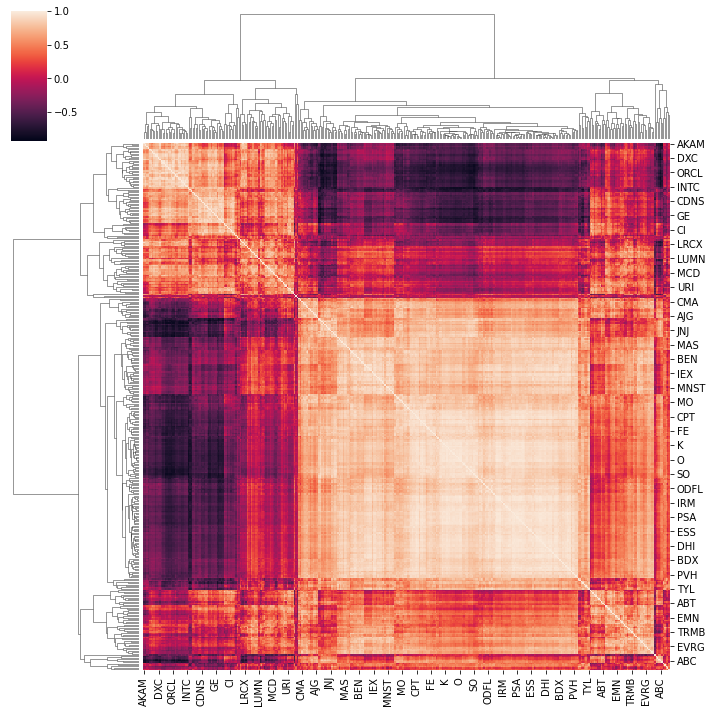

In [7]:
corr = five_year_data.corr()
plt.figure(figsize=(12,8))
sns.clustermap(corr)

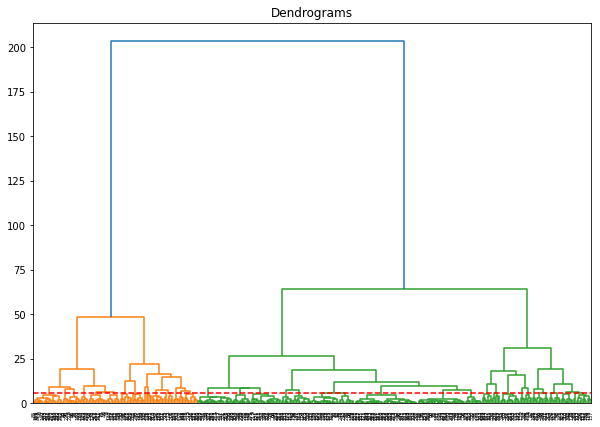

In [8]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(corr, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

In [9]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=4)  
kclusters = cluster.fit_predict(corr)
stock_clusters=pd.DataFrame(SP_Close.columns.values)
stock_clusters=stock_clusters.set_index(0)
stock_clusters['cluster']=kclusters
print(stock_clusters['cluster'].max())

64


In [10]:
#plt.hist(stock_clusters,bins=stock_clusters['cluster'].max())

In [11]:
#shrinkage
def calculate_posterior_mean(like_pop, prior_pop): #for returns use geo mean then multiply by 252 to annualize at end
    w0 = prior_pop.std()
    mu0 = prior_pop.mean() - w0**2/2
    w = like_pop.std()
    dbar = like_pop.mean() - w**2/2

    # Prior:
    prior = stats.norm(mu0, w0)
    
    # Likelihood:
    like = stats.norm(dbar, w)
    
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s * 252

## Markowitz Rebalancer

In [12]:
def Markowits_Bayes_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-.01,.1)):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [13]:
#monthly_vanilla_markowitz = Markowits_Bayes_Rebalance(SP_Close,21,252*5,verbose=False) #monthly rebalance with 5 year matrix

In [14]:
def Portfolio_backtest(weight_vector) :
    return_frame = SP_Close.loc[weight_vector.index]
    return_frame = np.exp(np.log(return_frame).diff())-1
    weighted_returns=weight_vector.shift(1)*return_frame
    port_returns = np.sum(weighted_returns, axis=1) #shift so that we are using the weights we had over that period rather than the ones we found with hindsight
    total_return=(port_returns+1).cumprod()
    total_return.plot()
    plt.title('Cumulative Return')
    return port_returns

In [15]:
#Portfolio_backtest(monthly_vanilla_markowitz)

## Implement Clustering Influenced Dynamic Constraints

In [16]:
def Cluster_Constraints(clusters,u_coef,l_coef): # weight coef for how overweight you can go
    cluster_list = set(clusters.cluster)
    cluster_map = dict(zip(clusters.index,clusters.cluster))
    cluster_totals=[clusters.value_counts()[x] for x in cluster_list]
    cluster_pct=np.array(cluster_totals)/len(clusters)
    cluster_upper_l = dict(zip(cluster_list, cluster_pct*u_coef))
    cluster_lower_l = dict(zip(cluster_list, - l_coef*cluster_pct))
    return cluster_map, cluster_upper_l, cluster_lower_l

In [17]:
#for testing preset clusters
def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

In [18]:
class constrained_clusterings_precomputed:
    
    def __init__(self,lookback):
        llist = [1,2,3,4,5]
        if (int(lookback) != lookback) or (int(lookback) not in llist):
            raise ValueError("Only lookback periods of",llist,"supported")
            
        self.df = pd.read_pickle(str(int(lookback))+'.pkl')
        self.names_df = pd.read_pickle('names.pkl')
        
#         corr_threshold = 0.7
#         pct_threshold = 0.1
#         date = datetime.strptime('3-31-2030','%m-%d-%Y')
        
            
    def calcthresholds(self,corr_threshold,pct_threshold,date,DEBUG=False):
        if date < min(self.df.index):
            raise ValueError("Date must be >=",min(self.df.index))
        if date > max(self.df.index):
            print("WARNING: USING",max(self.df.index),"FOR INPUT DATE",date)
        inddate = max(self.df.index[self.df.index <= date])
#         print(inddate)
#         print(self.df.loc[inddate])
        if DEBUG:
            print("DEBUG: USING",inddate,"FOR INPUT DATE",date)
        
        clusters = self.df.loc[inddate]['Clusters']
        numstocks = self.df.loc[inddate]['Numstocks']
        internals = self.df.loc[inddate]['Corrs']
        sz = clusters.shape[0]
        
        tmp = np.sum((internals<corr_threshold)*(numstocks/sz),axis=1)<pct_threshold
        ret = (np.arange(0,sz)+1)[tmp]
        if ret.shape[0] <= 0:
            return None
        OPTIMAL_NUMBER_OF_CLUSTERS = ret[0]
        if DEBUG:
            print("DEBUG: OPTIMAL NUMBER OF CLUSTERS:",OPTIMAL_NUMBER_OF_CLUSTERS)
        
        ret_df = self.names_df
        ret_df = ret_df.set_index(0)
        ret_df['cluster'] = clusters[OPTIMAL_NUMBER_OF_CLUSTERS-1,:].astype(int)
        
#         print(OPTIMAL_NUMBER_OF_CLUSTERS)
#         print(ret_df)
        return ret_df

In [19]:
import os
filelist = ['1.pkl','2.pkl','3.pkl','4.pkl','5.pkl','names.pkl']
for file in filelist:
    if not os.path.exists(file):
        raise ValueError("All of",filelist,"must be present")
        
look1 = constrained_clusterings_precomputed(1)
look2 = constrained_clusterings_precomputed(2)
look3 = constrained_clusterings_precomputed(3)
look4 = constrained_clusterings_precomputed(4)
look5 = constrained_clusterings_precomputed(5)

In [20]:
def get_clusters_precomputed(lookback,corr_threshold,pct_threshold,date,DEBUG=False):
    llist = [1,2,3,4,5]
    if (int(lookback) != lookback) or (int(lookback) not in llist):
        raise ValueError("Only lookback periods of",llist,"supported")
        
    # Apparently pattern matching wasn't implemented until Python 3.10
    if lookback == 1:
        return look1.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 2:
        return look2.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 3:
        return look3.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 4:
        return look4.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 5:
        return look5.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    else:
        raise ValueError("Something went wrong")

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
def Markowits_Bayes_Cluster_Rebalance(securities_vector, rebalance_period=21,prior_period = 253*5, update_period=0,
                                      verbose=False,weight_bounds=(-.01,.1), cluster_u_coef=1.25, cluster_l_coef=.5,
                                      corr_thresh = .75,leave_out_pct = .1, clust_num = None):
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    cluster_list=[]
    num=clust_num
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        update_vector = securities_vector[prior_period+p-update_period:prior_period+p]
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
        
        if clust_num == None:
            clusters= get_clusters_precomputed(prior_period/253,corr_thresh, leave_out_pct, date=prior_vector.index[-1])
            num = clusters.max().values[0]
            cluster_list.append(max(clusters))    
        else:
            clusters = get_clusters(prior_vector.corr(), cluster_number = clust_num)
            cluster_list.append(clust_num) 
        c_map, c_upper, c_lower = Cluster_Constraints(clusters,cluster_u_coef,cluster_l_coef)
        mu = mean_historical_return(prior_vector)  
        if update_period != 0:
            for i in range(num):
                stocksNcluster = clusters.loc[clusters['cluster']==i].index
                for stock in stocksNcluster:
                    mu.loc[stock] = calculate_posterior_mean(prior_vector[stock].pct_change().dropna().to_numpy(),
                                                             update_vector[stocksNcluster].pct_change().dropna().to_numpy())
        
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        ef.add_sector_constraints(c_map, c_lower, c_upper)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    cluster_ts=pd.DataFrame(cluster_list)
    cluster_ts.index=dates
    cluster_ts.columns = ['Clusters']
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df, cluster_ts

## Hyperparameter tuning

In [23]:
#cluster_constrained_markowitz_set_num, _ = Markowits_Bayes_Cluster_Rebalance(SP_Close,21,252*5,verbose=False,clust_num=40)
#Portfolio_backtest(cluster_constrained_markowitz_set_num)

In [24]:
import itertools
import random
import time
import copy
import pickle
#add stock thresh list
def random_grid_search(securities_vec, number_of_samples = 50, 
                       rebal_prd_list = [63,253],#[21,63,253],
                       prior_prd_list = [253,2*253,5*253],
                       update_prd_list = [21,63, 253],
                       low_stk_bound_list = [-.007, -.005, -.003],
                       up_stk_bound_list = [.01,.02,.05,.1],
                       cluster_u_coef_list = [2,3,5],
                       cluster_l_coef_list = [-.02, -.05, -.1],
                       corr_thesh_list = [.5,.6,.7,.8],
                       stock_tresh_list = [.05] ):

#     permutations = []
    tuple_returns_dict = {}
#     for rebal,prior,update,lstk,ustk,clu,cll,corr,stock in itertools.product(rebal_prd_list, prior_prd_list, update_prd_list, low_stk_bound_list, \
#                                                     up_stk_bound_list,cluster_u_coef_list, cluster_l_coef_list, corr_thesh_list, stock_tresh_list):
#         if update_prd_list >= rebal_prd_list:
#             permutations.append((rebal,prior,update,lstk,ustk,clu,cll,corr,stock))
#     list_of_tuples = random.sample(permutations, number_of_samples)

    PICKLE_NAME = 
    with open(PICKLE_NAME, 'rb') as handle:
        list_of_tuples_all = pickle.load(handle)
    list_of_tuples = copy.deepcopy(list_of_tuples_all)
    
    for tuuple_ind in range(min(number_of_samples,len(list_of_tuples))):
        tuuple = list_of_tuples[tuuple_ind]
        print(tuuple)
        try:
#             start = time.time()
            weights,_ = Markowits_Bayes_Cluster_Rebalance(securities_vec, rebalance_period=tuuple[0],prior_period = tuuple[1],update_period=tuuple[2],\
                                      verbose=False, weight_bounds=(tuuple[3],tuuple[4]), cluster_u_coef=tuuple[5], cluster_l_coef=tuuple[6],\
                                          corr_thresh = tuuple[7], leave_out_pct = tuuple[8], clust_num = None)
            performance_series = Portfolio_backtest(weights)
            performance_series = performance_series.loc["2005":]
#             print(start-time.time())
        except KeyboardInterrupt:
            print('KeyboardInterrupt')
            with open('res_'+str(int(time.time()))+'.pickle', 'wb') as handle:
                pickle.dump(tuple_returns_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(PICKLE_NAME, 'wb') as handle:
                pickle.dump(list_of_tuples_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
            return tuple_returns_dict
        except:
            weights = None
            performance_series = None
            print('Infeasible')
        
        list_of_tuples_all.pop(0)
        tuple_returns_dict[tuuple] = performance_series
#         print(performance_series)
#         return performance_series
    with open('res_'+str(int(time.time()))+'.pickle', 'wb') as handle:
        pickle.dump(tuple_returns_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(PICKLE_NAME, 'wb') as handle:
        pickle.dump(list_of_tuples_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return tuple_returns_dict

In [25]:
# import itertools
# import random
# import time
# import copy
# import pickle
# #add stock thresh list
# def random_grid_search(securities_vec, number_of_samples = 50, 
#                        rebal_prd_list = [63,253],#[21,63,253],
#                        prior_prd_list = [253,2*253,5*253],
#                        update_prd_list = [21,63, 253],
#                        low_stk_bound_list = [-.007, -.005, -.003],
#                        up_stk_bound_list = [.01,.02,.05,.1],
#                        cluster_u_coef_list = [2,3,5],
#                        cluster_l_coef_list = [-.02, -.05, -.1],
#                        corr_thesh_list = [.5,.6,.7,.8],
#                        stock_tresh_list = [.05] ):

# #     permutations = []
#     tuple_returns_dict = {}
# #     for rebal,prior,update,lstk,ustk,clu,cll,corr,stock in itertools.product(rebal_prd_list, prior_prd_list, update_prd_list, low_stk_bound_list, \
# #                                                     up_stk_bound_list,cluster_u_coef_list, cluster_l_coef_list, corr_thesh_list, stock_tresh_list):
# #         if update_prd_list >= rebal_prd_list:
# #             permutations.append((rebal,prior,update,lstk,ustk,clu,cll,corr,stock))
# #     list_of_tuples = random.sample(permutations, number_of_samples)

#     PICKLE_NAME = 'cc1.pickle'
#     with open(PICKLE_NAME, 'rb') as handle:
#         list_of_tuples_all = pickle.load(handle)
#     list_of_tuples = copy.deepcopy(list_of_tuples_all)
    
#     for tuuple_ind in range(min(number_of_samples,len(list_of_tuples))):
#         tuuple = list_of_tuples[tuuple_ind]
#         print(tuuple)
#         try:
# #             start = time.time()
#             assert(np.random.randint(0,2)==0)
#             performance_series = 1
# #             print(start-time.time())
#         except KeyboardInterrupt:
#             print('KeyboardInterrupt')
#             break
# #             with open('res_'+str(int(time.time()))+'.pickle', 'wb') as handle:
# #                 pickle.dump(tuple_returns_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# #             with open(PICKLE_NAME, 'wb') as handle:
# #                 pickle.dump(list_of_tuples_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
# #             return tuple_returns_dict
#         except:
#             performance_series = None
#             print('Infeasible')
        
#         list_of_tuples_all.pop(0)
#         tuple_returns_dict[tuuple] = performance_series
# #         print(performance_series)
# #         return performance_series
#     with open('res_'+str(int(time.time()))+'.pickle', 'wb') as handle:
#         pickle.dump(tuple_returns_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open(PICKLE_NAME, 'wb') as handle:
#         pickle.dump(list_of_tuples_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     return tuple_returns_dict

In [ ]:
for i in range(100):
    dictionary = random_grid_search(SP_Close[:'2018-01-01'], number_of_samples=30)

(63, 1265, 253, -0.005, 0.05, 5, -0.1, 0.8, 0.05)
KeyboardInterrupt
(63, 1265, 253, -0.005, 0.05, 5, -0.1, 0.8, 0.05)
KeyboardInterrupt
(63, 1265, 253, -0.005, 0.05, 5, -0.1, 0.8, 0.05)
KeyboardInterrupt
(63, 1265, 253, -0.005, 0.05, 5, -0.1, 0.8, 0.05)


In [35]:
with open('res_1652548211.pickle', 'rb') as handle:
    origg = pickle.load(handle)
print(origg)

{(63, 1265, 253, -0.003, 0.1, 3, -0.1, 0.8, 0.05): None, (253, 506, 253, -0.005, 0.05, 5, -0.02, 0.5, 0.05): None, (63, 253, 253, -0.007, 0.01, 5, -0.02, 0.8, 0.05): 1, (63, 506, 253, -0.003, 0.1, 2, -0.05, 0.7, 0.05): 1, (253, 253, 253, -0.005, 0.1, 2, -0.05, 0.6, 0.05): 1, (253, 253, 253, -0.005, 0.05, 5, -0.1, 0.7, 0.05): 1, (63, 1265, 253, -0.003, 0.05, 2, -0.05, 0.7, 0.05): None, (63, 506, 253, -0.007, 0.01, 5, -0.1, 0.6, 0.05): None, (63, 506, 63, -0.005, 0.02, 2, -0.05, 0.8, 0.05): None, (253, 253, 253, -0.003, 0.02, 2, -0.02, 0.6, 0.05): None, (63, 253, 253, -0.007, 0.01, 5, -0.1, 0.7, 0.05): None, (253, 506, 253, -0.005, 0.05, 3, -0.1, 0.8, 0.05): 1, (253, 1265, 253, -0.003, 0.05, 5, -0.05, 0.8, 0.05): 1, (253, 253, 253, -0.005, 0.1, 2, -0.1, 0.7, 0.05): None, (63, 1265, 63, -0.003, 0.05, 2, -0.1, 0.6, 0.05): None, (253, 506, 253, -0.007, 0.02, 2, -0.1, 0.8, 0.05): None, (253, 253, 253, -0.003, 0.01, 2, -0.1, 0.8, 0.05): 1, (63, 1265, 253, -0.003, 0.01, 2, -0.02, 0.5, 0.05): 1

In [28]:
with open('cc1.pickle', 'rb') as handle:
    origg = pickle.load(handle)
print(len(origg))
for i in origg:
    print(i)

0


## Make the ability to short stocks very minimal

In [97]:
returns_1, _ = Markowits_Bayes_Cluster_Rebalance(SP_Close,21,252*5, weight_bounds=(-.001,.2), cluster_u_coef=2, cluster_l_coef=.01,clust_num=50,verbose=False)

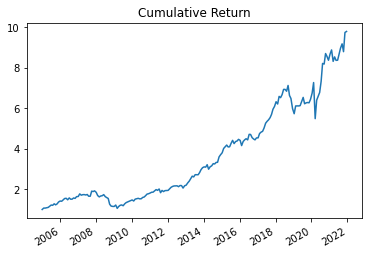

In [98]:
Portfolio_backtest(returns_1)

## Use Shrinkage on Clusters!

In [99]:
SP_Pre2018= SP_Close[:'2018-01-01']
SP_Pre2018.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,65.136894,41.969559,86.004715,191.639999,53.128281,175.000000,81.833572,35.416149,108.417572,103.889999,...,91.037071,27.875200,97.919571,29.092243,43.322823,66.389336,63.901493,76.503883,105.150002,46.593800
2017-12-26,65.040184,40.904797,86.739548,189.539993,53.193611,174.440002,81.630951,35.477825,109.057610,103.800003,...,91.917725,27.875200,97.575256,29.192158,42.945709,66.397255,64.328659,76.308914,104.790001,46.167164
2017-12-27,65.088531,40.911991,86.134926,190.419998,53.632221,175.360001,82.063835,35.460217,108.770058,104.580002,...,92.010406,27.938107,97.772003,29.225466,43.244251,66.333984,64.105347,76.503883,104.949997,46.031006
2017-12-28,65.233597,41.027103,86.125626,190.550003,53.622890,175.550003,82.321724,35.486645,108.816437,105.070000,...,92.140182,28.217251,97.408043,29.358679,43.497570,66.428864,64.579773,76.754570,104.279999,46.602879
2017-12-29,64.912766,40.583443,85.409386,187.410004,53.258942,175.240005,81.999359,35.319218,108.705132,104.830002,...,91.537659,28.170069,97.063744,29.358679,43.524696,66.128410,63.996483,75.770409,103.800003,46.139935


In [100]:
#3 month
returns_2, _ = Markowits_Bayes_Cluster_Rebalance(SP_Pre2018,63,252*5,63,weight_bounds=(-.001,.2), cluster_u_coef=2, cluster_l_coef=-.01,clust_num=50)

Iteration 1 of 52
2000-01-03 00:00:00 - 2005-01-06 00:00:00
Iteration 40 of 52
2000-04-03 00:00:00 - 2005-04-08 00:00:00
Iteration 40 of 52
2000-07-03 00:00:00 - 2005-07-08 00:00:00
Iteration 40 of 52
2000-10-02 00:00:00 - 2005-10-06 00:00:00
Iteration 40 of 52
2001-01-02 00:00:00 - 2006-01-06 00:00:00
Iteration 40 of 52
2001-04-03 00:00:00 - 2006-04-07 00:00:00
Iteration 40 of 52
2001-07-03 00:00:00 - 2006-07-10 00:00:00
Iteration 40 of 52
2001-10-08 00:00:00 - 2006-10-06 00:00:00
Iteration 40 of 52
2002-01-08 00:00:00 - 2007-01-09 00:00:00
Iteration 40 of 52
2002-04-10 00:00:00 - 2007-04-11 00:00:00
Iteration 40 of 52
2002-07-10 00:00:00 - 2007-07-11 00:00:00
Iteration 40 of 52
2002-10-08 00:00:00 - 2007-10-09 00:00:00
Iteration 40 of 52
2003-01-08 00:00:00 - 2008-01-09 00:00:00
Iteration 40 of 52
2003-04-09 00:00:00 - 2008-04-10 00:00:00
Iteration 40 of 52
2003-07-10 00:00:00 - 2008-07-10 00:00:00
Iteration 40 of 52
2003-10-08 00:00:00 - 2008-10-08 00:00:00
Iteration 40 of 52
2004-0

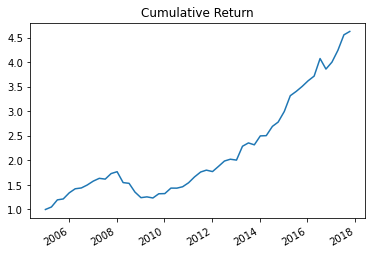

In [101]:
Portfolio_backtest(returns_2)